In [699]:
import pandas as pd
import subprocess
import math
import numpy as np
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import display
import scipy as sp
import scipy.stats

In [700]:
def f_cdf(x,mu,sigma):
    return scipy.stats.norm(mu,sigma).cdf(x)

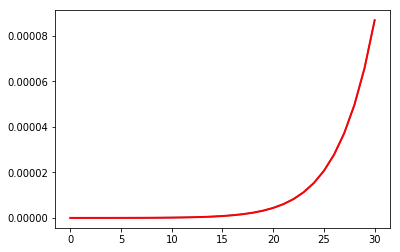

In [808]:
x_index=np.array(range(0,14,1))
expand_x_index=np.array(range(0,31,1))
interval=1
x_index=x_index*interval
fail_bits= np.array([0,0,0,1,4,14,37,85,143,216,328,447,650,867])#1434.4#1797 2216
rowhammer_bits=2*(0x1<<30)*8/8
y_index=fail_bits/rowhammer_bits
popt, pcov = curve_fit(fitting_func, x_index,y_index)
mu,sigma = scipy.optimize.curve_fit(f_cdf,x_index,y_index)[0]
#print(mu,sigma)
# plt.plot(x_index, y_index)
# plt.plot(x_index, f_cdf(x_index, mu,sigma), color='red', linewidth=2)

expand_y_index=[]

for i in range(0,31):
     expand_y_index=np.append(expand_y_index,f_cdf(i, mu,sigma))
        
plt.plot(expand_x_index, expand_y_index)
plt.plot(expand_x_index, f_cdf(expand_x_index, mu,sigma), color='red', linewidth=2)

In [809]:
# def access_to_rowhammer(num_access): #V1
#     #num_rowhammer_RT=[0,0,0,1,4,14,37,85,143,216,328,447,650,867]
#     num_rowhammer_RT=[0,0,0,1,4,14,37,85,143,216,328,447,650,867,1434.4,1797,2216,2695,3239,3851.7687165675748 ,
# 4537.151010742639 ,
# 5299.349709101644 ,
# 6142.442146074858 ,
# 7070.505656092558 ,
# 8087.617573585008 ,
# 9197.855232982485 ,
# 10405.29596871526 ,
# 11714.017115213604 ,
# 13128.096006907781]
#     rowhammer_bits=2*(0x1<<30)*8/8
#     quot=int(num_access/100)
#     remain=num_access%4
#     #print(num_access,quot,remain,rowhammer_bits)
#     if(remain==0): return (num_rowhammer_RT[quot])/rowhammer_bits
#     else:
#         return (num_rowhammer_RT[quot]*(4-remain)/4+num_rowhammer_RT[quot+1]*(remain)/4)/rowhammer_bits
        

In [810]:
def access_to_rowhammer(num_access):
    return expand_y_index[int(num_access/100)]

In [811]:
def cal1(p,n):
    #fail more than 1bit in 64 bit
    p_fail_64=64*p #approximation 1-(1-p)^64
    #print("cal1:",p_fail_64)
    return 1-np.exp(-n*p_fail_64/64)

def cal2(p,n):
    #fail more than 1bit in 64 bit
    p_fail_64=1-(1-63*p)*(1+63*p) #approximation 1-((1-p)^63)*(1+63*p)
    #print("cal2:",p_fail_64)
    return 1-np.exp(-n*p_fail_64/64)

In [812]:
#please write dram_size #Gb
def p_bitfail_to_p_dramfail(p_fail,dram_size):
    p_list=[]
    num_dram_bits=int(dram_size*(0x1<<33))
    #p_math=1-(1-p_fail)**(dram_size)
    #p_list.append(p_math)
    max_order=1000
    
    
    p1_approx=cal1(p_fail, num_dram_bits)
    #p_list.append(p1_approx)
    
    p2_approx=cal2(p_fail, num_dram_bits)
    #p_list.append(p2_approx)
    
#     p_approx=0
#     for n in range(1,max_order):
#         sign=1 if (n%2) else -1
#         delta_p=1
#         for i in range(1,n+1):
#             delta_p=delta_p*mul_p_dram_size/i
#         p_approx=p_approx+sign*delta_p
#         if(delta_p<0.1**(20)):
#             break
    return p1_approx,p2_approx
    

In [813]:
print("\nstart real_data\n")
del real_data
real_data=pd.DataFrame(columns=["theshold","p_fail", "RHth_NT 1st","RHth_NT 2nd","RHth_LT 1st","RHth_LT 2nd"])
for i in range(0,2900,100):
    p_fail=access_to_rowhammer(i)
    p1_RT,p2_RT=p_bitfail_to_p_dramfail(p_fail,2)
    p1_LT,p2_LT=p_bitfail_to_p_dramfail(p_fail*0.02,2)
    real_data=real_data.append({"theshold":i,"p_fail":p_fail, "RHth_NT 1st":p1_RT,"RHth_NT 2nd":p2_RT,"RHth_LT 1st":p1_LT,"RHth_LT 2nd":p2_LT},ignore_index=True)
print(real_data)

print("\n start p_data \n")
p_data=pd.DataFrame(columns=["p_fail", "RHth_NT 1st","RHth_NT 2nd","RHth_LT 1st","RHth_LT 2nd"])
for i in range(1,10000):
    p_fail=i*0.1**(9)
    p1,p2=p_bitfail_to_p_dramfail(p_fail,2)
    p1_LT,p2_LT=p_bitfail_to_p_dramfail(p_fail*0.02,2)
    p_data=p_data.append({"p_fail":p_fail, "RHth_NT 1st":p1,"RHth_NT 2nd":p2,"RHth_LT 1st":p1_LT,"RHth_LT 2nd":p2_LT},ignore_index=True)
print(p_data)
    
    


start real_data

    theshold        p_fail  RHth_NT 1st  RHth_NT 2nd  RHth_LT 1st  \
0        0.0  2.848562e-09          1.0     0.000009     0.624223   
1      100.0  4.296941e-09          1.0     0.000020     0.771545   
2      200.0  6.451736e-09          1.0     0.000044     0.891043   
3      300.0  9.642246e-09          1.0     0.000099     0.963595   
4      400.0  1.434384e-08          1.0     0.000219     0.992763   
5      500.0  2.123928e-08          1.0     0.000481     0.999323   
6      600.0  3.130416e-08          1.0     0.001043     0.999979   
7      700.0  4.592548e-08          1.0     0.002245     1.000000   
8      800.0  6.706501e-08          1.0     0.004780     1.000000   
9      900.0  9.748331e-08          1.0     0.010074     1.000000   
10    1000.0  1.410451e-07          1.0     0.020972     1.000000   
11    1100.0  2.031330e-07          1.0     0.043010     1.000000   
12    1200.0  2.912052e-07          1.0     0.086387     1.000000   
13    1300.0  4.

In [814]:
def graph_scatter(data,x_col,y_col,xlabel,ylabel):
    color=["Red","Blue","Green","Black","Yellow","Purple"]
    first_graph=1
    for i,index in enumerate(y_col):
        col_list=data.columns
        if(first_graph==1):
            first_graph=0
            ax1=data.plot(kind='scatter',title="RH_th",x=col_list[x_col],y=col_list[index],c=color[i],label=col_list[index])
#             ax1=data.plot(kind='scatter',title="Retention time",x="index",y=columns,c=color[index],label=columns,logx=True)
        else:
            data.plot(kind='scatter',title="RH_th",x=col_list[x_col],y=col_list[index],c=color[i],label=col_list[index],ax=ax1)
#             ax1=data.plot(kind='scatter',title="Retention time",x="index",y=columns,c=color[index],label=columns,logx=True,ax=ax1)
#    ax1.set_ylim(1,200000000)
    ax1.autoscale(enable=True, axis='both', tight=None)
    print(ax1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [815]:
def graph_scatter_scale(data,x_col,y_col,xlabel,ylabel,x_scale=(0,0),y_scale=(0,0),xlog=False,ylog=False):
    color=["Red","Blue","Green","Black","Yellow","Purple"]
    first_graph=1
    for i,index in enumerate(y_col):
        col_list=data.columns
        if(first_graph==1):
            first_graph=0
#            ax1=data.plot(kind='scatter',title="RH_th",x=col_list[x_col],y=col_list[index],c=color[i],label=col_list[index])
            ax1=data.plot(kind='scatter',title="RH_th",x=col_list[x_col],y=col_list[index],c=color[i],label=col_list[index],logx=xlog,logy=ylog)
        else:
#            data.plot(kind='scatter',title="RH_th",x=col_list[x_col],y=col_list[index],c=color[i],label=col_list[index],ax=ax1)
             ax1=data.plot(kind='scatter',title="RH_th",x=col_list[x_col],y=col_list[index],c=color[i],label=col_list[index],logx=xlog,logy=ylog,ax=ax1)
    ax1.axhline(y=0.01, color='r', linestyle='--')
    ax1.autoscale(enable=True, axis='both', tight=True)
    if(x_scale!=(0,0)):
        ax1.set_xlim(x_scale)
    if(y_scale!=(0,0)):
        ax1.set_ylim(y_scale)
#    ax1.autoscale(enable=True, axis='both', tight=True)
    print(ax1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [816]:
def graph_scatter3(data,x_col,xscale,y_col,xlabel,ylabel):
    color=["Red","Blue","Green","Black","Yellow","Purple"]
    first_graph=1
    first,last=y_col
    for i,index in enumerate(range(first,last)):
        col_list=data.columns
        if(first_graph==1):
            first_graph=0
            ax1=data.plot(kind='scatter',title="RH_th",x=col_list[x_col],y=col_list[index],c=color[i],label=col_list[index])
#             ax1=data.plot(kind='scatter',title="Retention time",x="index",y=columns,c=color[index],label=columns,logx=True)
        else:
            data.plot(kind='scatter',title="RH_th",x=col_list[x_col],y=col_list[index],c=color[i],label=col_list[index],ax=ax1)
#             ax1=data.plot(kind='scatter',title="Retention time",x="index",y=columns,c=color[index],label=columns,logx=True,ax=ax1)
    ax1.set_ylim(0.1**10,0.1**7)
    print(ax1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


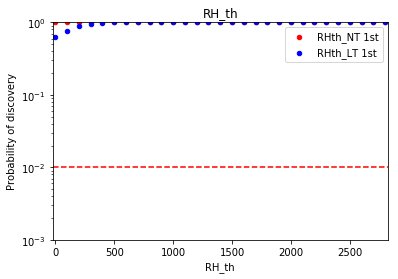

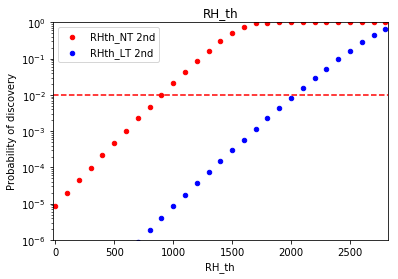

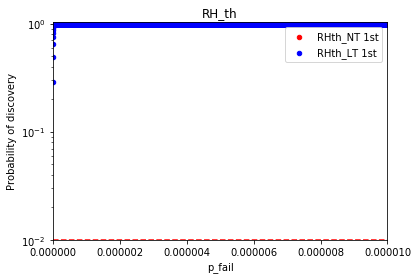

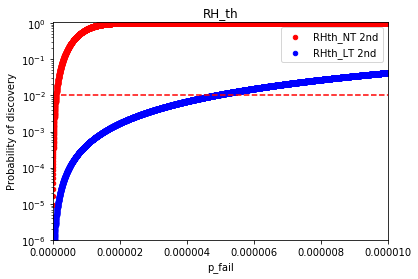

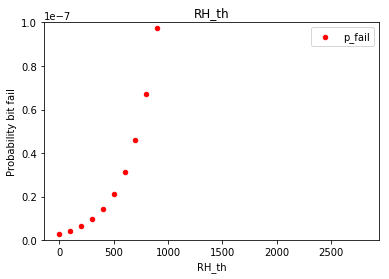

In [817]:
graph_scatter_scale(real_data,0,[2,4],"RH_th","Probability of discovery",y_scale=(0.1**3,1),xlog=False,ylog=True)
graph_scatter_scale(real_data,0,[3,5],"RH_th","Probability of discovery",y_scale=(0.1**6,1),xlog=False,ylog=True)
graph_scatter_scale(p_data,0,[1,3],"p_fail","Probability of discovery",(0,0.1**5),xlog=False,ylog=True)
graph_scatter_scale(p_data,0,[2,4],"p_fail","Probability of discovery",(0,0.1**5),xlog=False,ylog=True)
graph_scatter3(real_data,0,0.1**10,(1,2),"RH_th","Probability bit fail")

In [688]:
para_1=[9709721, 181856 , 2248, 18]
para_2=[2632280, 13638 , 47, 0]
para_3=[141821,42,0,0]

In [673]:
def p_1bit_fail_to_p_fail(p_1bit_fail):
    return 1-(1-p_1bit_fail)**(1/64)
    #return p_1bit_fail/64

In [674]:
def para_eval(para_data,row=False):
    num_of_world=(0x1<<29)
    p_1bit_fail=para_data[0]/num_of_world
    p_fail=p_1bit_fail_to_p_fail(p_1bit_fail)
    p_2bit_fail=1-(1-63*p_fail)*(1+63*p_fail)
    print(p_2bit_fail*num_of_world)

In [675]:
para_eval(para_1)
para_eval(para_2)
para_eval(para_3)


173242.8497904539
12566.542442798615
36.311593532562256


In [676]:
AED_1=[10790,110]
AED_2=[14977,123]
AED_3=[89272,7385]
AED_4=[136008+12450,12450]
AED_5=[6042,35]
AED_6=[13758,28]

In [677]:
def AED_eval(para_data,row=False):
    num_of_row=(0x1<<28)
    p_1bit_fail=para_data[0]/num_of_row
    p_fail=p_1bit_fail_to_p_fail(p_1bit_fail)
    #print(p_fail)
    p_2bit_fail=1-(1-63*p_fail)*(1+63*p_fail)
    print(p_2bit_fail*num_of_row)

In [678]:
AED_eval(AED_1)
AED_eval(AED_2)
AED_eval(AED_3)
AED_eval(AED_4)
AED_eval(AED_5)
AED_eval(AED_6)

0.4202825427055359
0.8097571730613708
28.77756178379059
79.60218173265457
0.13178086280822754
0.6833037436008453
